In [1]:
# Importing required packages
import os
import re
import string

from collections import defaultdict
from collections import  Counter

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.initializers import Constant
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, BatchNormalization
from keras.layers.core import Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/DS_Work/News Clf Proper
!dir

/content/drive/My Drive/DS_Work/News Clf Proper
Data	    News_Classification_Using_CNN.ipynb
Embeddings  News_Classification_Using_LSTM.ipynb
Models	    News_Classification_Using_NB_LR.ipynb


In [4]:
# Navigate to data and save paths to required files
# %cd drive/My\ Drive
# %cd DS_Work

PATH_DATA_CSV = 'Data/newsCorpora_edited.csv'
PATH_EMBEDDING_GLOVE = 'Embeddings/glove.6B.100d.txt'

# Note: `newsCorpora_edited.csv` is a simple revision which has usable headers

In [5]:
# Read csv
data = pd.read_csv(PATH_DATA_CSV, sep='\t')
data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [6]:
# b: 'business',
# t: 'science and tech',
# e: 'entertainment',
# m: 'health'
# Mapping targets to integers

data['CATEGORY'] = data['CATEGORY'].map({'b': 0, 't': 1, 'e': 2, 'm':3})

In [7]:
# Creating holdout set
data_train = data.sample(frac=0.7, random_state=42).copy()
data_holdout = data[ data.index.isin(data_train.index) == False ].copy()

In [8]:
def remove_punct(text):
    '''Uses `maketrans` to create a translation table 
    and uses `z=string.punctuation` to remove punctuation'''
    import string
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [9]:
# Removing Punctuation and creating holdout set
data_train['TITLE'] = data_train['TITLE'].apply(lambda x: remove_punct(x))
data_holdout['TITLE'] = data_holdout['TITLE'].apply(lambda x: remove_punct(x))

In [10]:
# Creating a corpus using `word_tokenize`
corpus = []

for words_list in tqdm(data_train['TITLE'].str.strip().str.split()):
    words = [word.lower() for word in word_tokenize(' '.join(words_list))]
    corpus.append(words)

100%|██████████| 295693/295693 [00:29<00:00, 9991.95it/s] 


In [11]:
# Importing GloVe embeddings and storing in dictionary `embedding_dict`
embedding_dict = {}

with open(PATH_EMBEDDING_GLOVE, 'r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors
    f.close()

400000it [00:12, 31220.20it/s]


In [12]:
title_lengths = (data['TITLE'].apply(lambda x: len(x.split(' ')))).value_counts().sort_index()

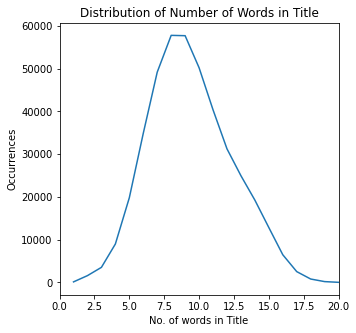

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(0, 20)
ax.plot(title_lengths)
plt.xlabel('No. of words in Title')
plt.ylabel('Occurrences')
plt.title('Distribution of Number of Words in Title')
plt.show();

In [14]:
# Converting series of words in Titles to a 
# series of sequences using `Tokenizer`
HEADLINE_MAXLEN = 20

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)

sequences = tokenizer_obj.texts_to_sequences(corpus)

In [15]:
# Padding the sequences (post) in order to have
# uniform data to input in the ANN
headline_padded = pad_sequences(sequences, maxlen=HEADLINE_MAXLEN,
                                truncating='post', padding='post')

In [16]:
word_index = tokenizer_obj.word_index
print('Number of unique words:', len(word_index))

Number of unique words: 62954


In [17]:
# Adding 1 to `num_words` to represent the padding
# Padding's embeddings refer to '0'*100
num_words = len(word_index) + 1

embedding_matrix = np.zeros((num_words, 100))

for word, sequence_num in tqdm(word_index.items()):
    if sequence_num > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    
    if emb_vec is not None:
        embedding_matrix[sequence_num] = emb_vec

100%|██████████| 62954/62954 [00:00<00:00, 677380.18it/s]


In [18]:
model = Sequential()

embedding = Embedding(num_words, 100, 
                      embeddings_initializer=Constant(embedding_matrix),
                      input_length=HEADLINE_MAXLEN, 
                      trainable=False)
model.add(embedding)

# Using spatial dropout instead of dropout in order to drop
# the same Nth embedding instead of random embeddings across sequences
model.add(SpatialDropout1D(0.2))

model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           6295500   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 6,338,000
Trainable params: 42,500
Non-trainable params: 6,295,500
_________________________________________________________________


In [19]:
optimizer = Adam(learning_rate=1e-5)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=16,
                           restore_best_weights=True)

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(headline_padded, pd.get_dummies(data_train['CATEGORY']),
                                                    test_size=0.15, stratify=data_train['CATEGORY'],
                                                    random_state=42)

In [22]:
print('Shape of train: ', X_train.shape)
print("Shape of Validation: ", X_test.shape)

Shape of train:  (251339, 20)
Shape of Validation:  (44354, 20)


In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    verbose=2)

Epoch 1/10
7855/7855 - 544s - loss: 0.9188 - accuracy: 0.6184 - val_loss: 0.6224 - val_accuracy: 0.7774
Epoch 2/10
7855/7855 - 551s - loss: 0.6523 - accuracy: 0.7577 - val_loss: 0.5356 - val_accuracy: 0.8057
Epoch 3/10
7855/7855 - 554s - loss: 0.5920 - accuracy: 0.7804 - val_loss: 0.4988 - val_accuracy: 0.8187
Epoch 4/10
7855/7855 - 537s - loss: 0.5605 - accuracy: 0.7932 - val_loss: 0.4779 - val_accuracy: 0.8259
Epoch 5/10
7855/7855 - 535s - loss: 0.5417 - accuracy: 0.8003 - val_loss: 0.4605 - val_accuracy: 0.8323
Epoch 6/10
7855/7855 - 534s - loss: 0.5260 - accuracy: 0.8062 - val_loss: 0.4495 - val_accuracy: 0.8362
Epoch 7/10
7855/7855 - 553s - loss: 0.5149 - accuracy: 0.8100 - val_loss: 0.4409 - val_accuracy: 0.8389
Epoch 8/10


In [ ]:
history.history.keys()

In [ ]:
for key in history.history.keys():
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 128)
    plt.plot(history.history[key])
    plt.title(key)
    plt.show();

In [ ]:
PATH_MODEL = 'Models/news_clf_lstm_3.model'

In [ ]:
model.save(PATH_MODEL)

In [ ]:
# fLoading trained model
from tensorflow.keras.models import load_model

model = load_model(PATH_MODEL, compile=False)

In [ ]:
# Preprocessing holdout set in order to get predictions
# Removing punctuation
data_holdout['TITLE'] = data_holdout['TITLE'].apply(lambda x: remove_punct(x))

# Creating a corpus
corpus_holdout = []

for words_list in tqdm(data_holdout['TITLE'].str.strip().str.split()):
    words = [word.lower() for word in word_tokenize(' '.join(words_list))]
    corpus_holdout.append(words)

# Converting to sequence
sequences_holdout = tokenizer_obj.texts_to_sequences(corpus_holdout)

# Padding sequences
headline_padded_holdout = pad_sequences(sequences_holdout, maxlen=HEADLINE_MAXLEN,
                                        truncating='post', padding='post')

# One-hot encoding for target variables
holdout_target = pd.get_dummies(data_holdout['CATEGORY'])

In [ ]:
# Getting probablities
y_pred = model.predict(headline_padded_holdout)

In [ ]:
# Converting to df and performing argmax for single variable output
y_pred = pd.DataFrame(data=y_pred, index=holdout_target.index, 
                      columns=holdout_target.columns)

In [ ]:
def onehot_to_series(df):
    '''Converts softmax output to single variable discrete ouput'''
    sr = np.zeros_like(df)
    sr[np.arange(len(df)), df.values.argmax(1)] = 1
    sr = pd.DataFrame(sr, columns = df.columns).astype(int)
    sr = sr.idxmax(axis=1)
    sr.index = df.index
    return sr

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy_score(onehot_to_series(holdout_target).map({0: 'business', 1: 'science', 2:'entertainment', 3:'health'}), 
               onehot_to_series(y_pred).map({0: 'business', 1: 'science', 2:'entertainment', 3:'health'}),
               )

In [ ]:
print(classification_report(onehot_to_series(holdout_target).map({0: 'business', 1: 'science', 2:'entertainment', 3:'health'}), 
                            onehot_to_series(y_pred).map({0: 'business', 1: 'science', 2:'entertainment', 3:'health'}),))

In [ ]:
print("Check 1")

In [ ]:
print("Check 2")

---